# MACHINE LEARNING FOR PUBLIC POLICY
# Homework 2 - Cristina Mac Gregor Vanegas
### Due: April 17, 2018

The notebook is organized in the following way: First, all functions created in order to carry out the analysis are defined, for points 1 through 6. On a second part of the notebook, the functions are called ot excecute the analyisis
#### PART 1.A:
     1. Loading data
     2. Exploring data
     3. Pre-processing data
     4. Generating features and predictors. 
#### Part 1.B: 
     5. Building KNN classifier
     6. Evaluating the classifier. 
#### Part 2.A
    Running exploatory analysis
#### Part 2.B
    Running model

## PART 1.A


##### Read Data functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import geopandas as gpd
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

/Users/crismacgregor/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
def read_files(file_name):
    '''
    Reading in downloaded csv files.
    '''
    dframe = pd.read_csv(file_name)
    return dframe

##### Exploring and pre-processing data functions

In [3]:
def check_mv(frame, var):
    '''
    Prints out percentage of missing values for a given variable.
    '''
    frame["temp"] = frame[var].apply(lambda x: x if float(x) else np.nan)
    frame["temp2"] = frame[var].apply(lambda x: 1 if pd.isnull(x) else 0)
    print("Missing values", frame["temp2"].value_counts(True))


In [4]:
def clean_var(frame, var):
    '''
    Cleans variables from unwanted characters; removes outliers and fills in missing values 
    '''
    frame[var] = frame[var].apply(lambda x: np.nan if (x == "-") else float(x))
    
    #Winzorizing process: setting outliers to the value of the 99 percentile. 
    x99 = frame[var].quantile(.99)
    frame[var] = frame[var].apply(lambda x: x99 if x > x99  else x)  
    #Setting missing values to be the value of the mean
    x50 = frame[var].mean()
    frame[var] = frame[var].apply(lambda x: x50 if pd.isnull(x) else x)  
    
    return frame

In [5]:
def get_stats(frame, target_var, group_vars = None):
    '''
    Prints general statistics for each variable, and if specified, also 
    means of grouped-by varibales, grouped by specified groups. 
    '''
    
    if not group_vars :
        print("\n", target_var, frame[target_var].describe())
        print(frame[target_var].value_counts(True))
    
    if group_vars is not None: 
        print(frame.groupby(group_vars)[target_var].mean())

In [6]:
def get_geo(shape_file, frame, var, shp_name, level_str):
    '''
    Creates a geopandas file at the geographical level specified, given a pandas
    dataframe and a shape or geojson file.
    Inputs: shape_file: shapefile or geojson file
            frame: pandas frame
            shp_name: name of column in geojson file
            level_str: name of column in frame
    Outputs:
        Extended geo frame (geopandas object)

    '''
    frame.groupby()
    geo_df = gpd.read_file(shape_file)
    geo_df = geo_df.rename(columns={shp_name: level_str})
    geo_df_ext = geo_df.merge(frame, on=level_str, how = 'left')
    return geo_df_ext

In [7]:
def print_map_byvar(frame, varbs):
    '''
    Plots a map of the geographic distribution of the variables we wish to see. 
    '''
    for i in varbs:
        geo_df.plot(column=i, cmap='OrRd')
        plt.title(i)
        plt.show()

In [8]:
def show_cor(frame):
    '''
    Prints spearman correlations from a complete dataframe
    '''
    return frame.corr("spearman")


In [9]:
def scat(frame, varbs, target_var):
    '''
    Prints scatter plots for all the possible features against the predicted variable. 
    '''
    pairs = []
    for i in varbs:
            plt.scatter(frame[target_var], frame[i])
            plt.title("{} vs {}".format(target_var, i))
            plt.xlabel(target_var)
            plt.ylabel(i)
            plt.show()


##### Generate features functions

In [10]:
def discretize_quartiles(frame, var):
    '''
    Returns a discrete variable with 
    '''
    new_name = str(var) + "_discrete_q" 
    x25 = frame[var].quantile(.25)    
    x50 = frame[var].quantile(.50)    
    x75 = frame[var].quantile(.75)
    x100 = frame[var].max()
    buckets = [x25, x50, x75, x100]
    frame[new_name] = frame.apply(cats, axis=1, args = (buckets, var))  

    return frame

In [11]:
def cats(row, buckets, var):
    last = 0 
    gr = 1
    for i in buckets: 
        if (row[var]<= i) and (row[var]> last): 
            return gr
        gr += 1
        last = i


In [12]:
def make_dummies(frame, var, threshold = None):
    '''
    Makes dummy variables for each category of a discrete variable. 
    '''
    if threshold: 
        new_name = str(var) + "_d" 
        frame[new_name] = frame.apply(lambda x: 1 if x[var] < threshold else 0)
    else:
        buckets = frame[var].unique()
        for i in buckets: 
            new_name = str(var) + "_d_" + str(i)
            frame[new_name] = frame[var].apply(lambda x: 1 if x == i else 0)
            
    return frame

## PART 1.B 

##### Build classifier

In [13]:
def drop_feats(varbs, frame):
    '''
    Deletes variables that we don't want to include as predicitve features
    '''
    f2 = frame.drop(varbs, axis=1)
    return f2

In [14]:
def split(frame, test_percentage, target_var):
    '''
    Splits data into train and test sections. 
    '''
    X = frame.drop(target_var, axis=1)
    Y = frame[target_var]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_percentage)

    return  x_train, x_test, y_train, y_test

In [15]:
def knn_f(x_tr, y_tr, x_tst, y_tst, nn = 10, p =3, weights_ = 'distance'):
    '''
    Fits model and applies to testing data according to the specificities provided
    for the adjustment of the model.
    '''
    knn = KNeighborsClassifier(n_neighbors=nn, metric='minkowski', metric_params={'p': p}, weights=weights_)
    knn.fit(x_tr, y_tr)
    preds = knn.predict_proba(x_tst)
    return preds[:,1]

##### Evaluate classifier

In [16]:
def test_evals(output_array, real_vals, evals, threshold):
    '''
    Returns an evaluation meassure according to the test
    predictions and true values, according to a given threshold
    and according to the specified meassure of evaluation. 
    Inputs:
        output_array: (array) predicted values from test fraction of the data
        real_vals: (array) true values from test fraction of data (y_test)
        evals: (str) meassure of evaluation. Can be accuracy, recall, precision 
                    or specificity
        threshold: (float) threshold for predicted probabilities. 
    Outputs: 
        Score (float)
    '''
    
    test = {'pred': output_array, 'real': real_vals}
    test_f = pd.DataFrame(data=test)   
    TP, FP, TN, FN = 0, 0, 0, 0
    
    for indx, row in test_f.iterrows():
        status_predicted = 0
        if row["pred"] > threshold:
            status_predicted= 1 
        if (status_predicted == 1) and (row["real"]==1):
            TP += 1
        if (status_predicted == 1) and (row["real"]==0):
            FP += 1
        if (status_predicted == 0) and (row["real"]==0):
            TN += 1
        if (status_predicted == 0) and (row["real"]==1):
            FN += 1
        
            
    if (evals == 'accuracy') and((TP + TN + FP + FN) != 0):
       
        return (TP + TN) / (TP + TN + FP + FN)
    elif (evals == 'recall') and ((TP + FN)  != 0):
        return (TP) / (TP + FN)
    elif (evals == 'precision') and ((TP + FP )!= 0) :
        return (TP) / (TP + FP )
    elif (evals == 'specificity') and  ((TN) / (TN + FN) != 0):
        return (TN) / (TN + FN)
    else:
        return 0

In [17]:
def test_models(pvals, numn, weights, tested_param, threshold):
    '''
    Tests all possible specifications for a knn model given 
    -pvals (tuple) : the range of values for p in the knn model specification
    -numn (list) : the values of number of nieghbohrs that we want to test
    -weights (list) : kind of weights applied 
    -tested_param (str): meassure of evaluation. Can be accuracy, recall, precision 
                    or specificity
    -threshold (float):  threshold for predicted probabilities. 
    Outputs the information for the best model. 
    '''
    accuracy = 0 
    keep = (0,0,0,0)
    for p_vals in range(pvals[0], pvals[1]):
        for num_n in numn:
            for w in weights:
                pred = knn_f(xtrain, ytrain, xtest, ytest, num_n, p_vals, w)
                score_ = test_evals(pred, ytest, tested_param, threshold)
                
                
                if score_ > accuracy:
                    keep = (p_vals, num_n, w, score_)
                    accuracy = score_
    
    return keep 

## PART 2.A


In [18]:
csv = "data/credit-data.csv"
geo = "data/chi_boundaries_zip.geojson"
fr = read_files(csv)
fr.head()

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0


In [19]:
all_vars = ["SeriousDlqin2yrs", "RevolvingUtilizationOfUnsecuredLines", "age", 
            "zipcode", "NumberOfTime30-59DaysPastDueNotWorse", "DebtRatio", 
            "MonthlyIncome","NumberOfOpenCreditLinesAndLoans", "NumberOfTimes90DaysLate", 
            "NumberRealEstateLoansOrLines", "NumberOfTime60-89DaysPastDueNotWorse",
            "NumberOfDependents"]

trgt_var = "SeriousDlqin2yrs"
for i in all_vars:
    print ("******", i,"****** \n")
    print("Missing values percentages; 0 = not missing; 1 = mv")
    check_mv(fr, i)
    print("-----------")
    get_stats(fr, i)
    print("----------- \n" )


****** SeriousDlqin2yrs ****** 

Missing values percentages; 0 = not missing; 1 = mv
Missing values 0    1.0
Name: temp2, dtype: float64
-----------

 SeriousDlqin2yrs count    41016.000000
mean         0.161400
std          0.367904
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: SeriousDlqin2yrs, dtype: float64
0    0.8386
1    0.1614
Name: SeriousDlqin2yrs, dtype: float64
----------- 

****** RevolvingUtilizationOfUnsecuredLines ****** 

Missing values percentages; 0 = not missing; 1 = mv
Missing values 0    1.0
Name: temp2, dtype: float64
-----------

 RevolvingUtilizationOfUnsecuredLines count    41016.00000
mean         6.37587
std        221.61895
min          0.00000
25%          0.03431
50%          0.18973
75%          0.66716
max      22000.00000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64
1.000000    0.079432
0.000000    0.068364
1.000000    0.000122
0.950100    0.000098
0.713147    0.000098



****** NumberRealEstateLoansOrLines ****** 

Missing values percentages; 0 = not missing; 1 = mv
Missing values 0    1.0
Name: temp2, dtype: float64
-----------

 NumberRealEstateLoansOrLines count    41016.000000
mean         1.008801
std          1.153826
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max         32.000000
Name: NumberRealEstateLoansOrLines, dtype: float64
0     0.385557
1     0.342964
2     0.204871
3     0.040472
4     0.014702
5     0.005217
6     0.002462
7     0.001341
9     0.000683
8     0.000585
10    0.000293
12    0.000219
11    0.000195
13    0.000171
15    0.000073
14    0.000049
19    0.000024
16    0.000024
17    0.000024
18    0.000024
32    0.000024
25    0.000024
Name: NumberRealEstateLoansOrLines, dtype: float64
----------- 

****** NumberOfTime60-89DaysPastDueNotWorse ****** 

Missing values percentages; 0 = not missing; 1 = mv
Missing values 0    1.0
Name: temp2, dtype: float64
-----------

 NumberOfTime60

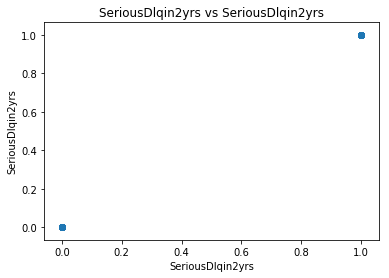

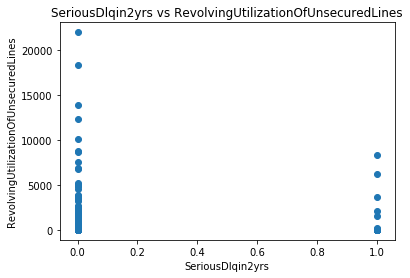

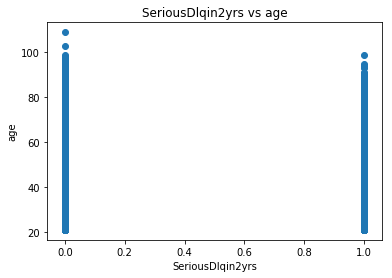

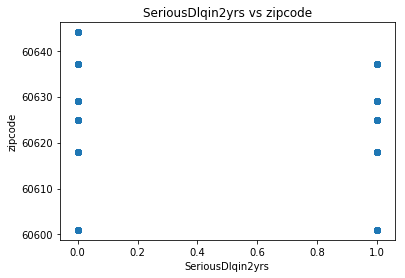

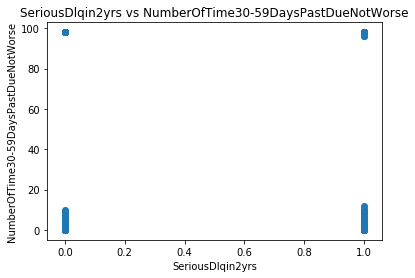

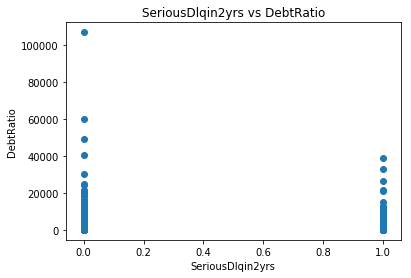

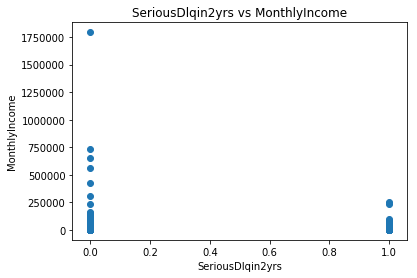

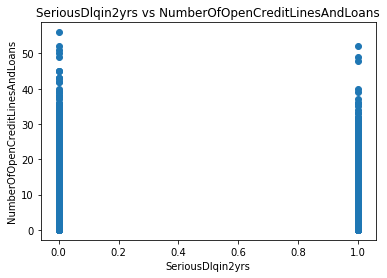

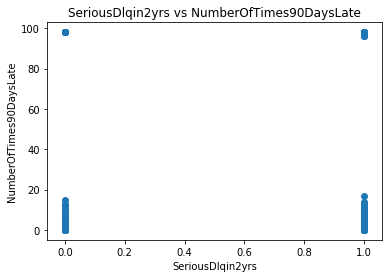

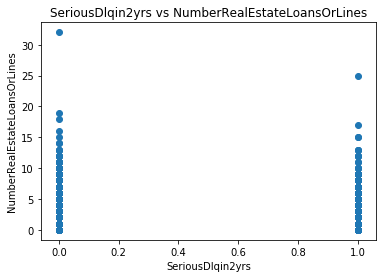

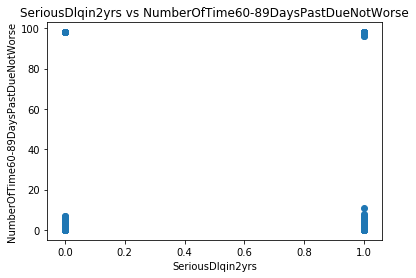

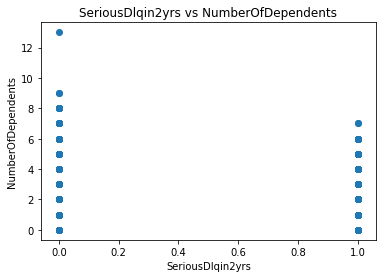

NameError: name 'x' is not defined

In [20]:
scat(fr, all_vars, trgt_var)

corr = show_cor(fr)
x #shows correlation grid 

#we are particularly interested in the way seriousDIqin2yrs is related to other variables. We see that variables who have higher relation are Revolving Utilization of Unsecuted lines, and all the variables counting the number of times late, in particular the number of times 90 days late.
#Since, in turn, NumberOfTimes90DaysLate is relatively highly correlated with those meassuring DaysPastDueNotWorse, we will only focus on this variable from this group. 

# Age seems to be relatively strong, but zipcode and number of dependents seems less strongly correlated. We proceed to 
# observe dinamics grouping by zipcode and number of dependents. Monthly income is moderately and negatively correlated with 
# the target variable

In [21]:
vars_selected = ["SeriousDlqin2yrs", "age", "DebtRatio", 
            "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans", 
            "NumberRealEstateLoansOrLines", "NumberOfDependents"]

#Printing stats by zipcode
for i in vars_selected: 
    print ("******", i,"****** \n")
    get_stats(fr, i, "zipcode")
    print("----------- \n" )

****** SeriousDlqin2yrs ****** 

zipcode
60601    0.169753
60618    0.176406
60625    0.169560
60629    0.166744
60637    0.180516
60644    0.000000
Name: SeriousDlqin2yrs, dtype: float64
----------- 

****** age ****** 

zipcode
60601    51.650848
60618    51.623026
60625    51.720707
60629    51.498529
60637    51.426503
60644    52.840945
Name: age, dtype: float64
----------- 

****** DebtRatio ****** 

zipcode
60601    326.090201
60618    351.840384
60625    318.771680
60629    319.513465
60637    355.413892
60644    329.127883
Name: DebtRatio, dtype: float64
----------- 

****** MonthlyIncome ****** 

zipcode
60601    6939.742488
60618    6414.652413
60625    6506.113519
60629    6437.078613
60637    6389.541109
60644    7274.661621
Name: MonthlyIncome, dtype: float64
----------- 

****** NumberOfOpenCreditLinesAndLoans ****** 

zipcode
60601    8.569784
60618    8.338598
60625    8.398171
60629    8.329463
60637    8.330973
60644    8.540945
Name: NumberOfOpenCreditLinesAndLoans,

In [22]:
test_percentage = .3
# we can also further loop changing test percentage. 
vars_remove = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTime60-89DaysPastDueNotWorse", "temp", "temp2"]
fr2 = drop_feats(vars_remove, fr)

In [23]:
fr = discretize_quartiles(fr, "age")
fr = make_dummies(fr, "age_discrete_q")


In [24]:
feats = ["RevolvingUtilizationOfUnsecuredLines",  
         "zipcode","DebtRatio", "MonthlyIncome","NumberOfOpenCreditLinesAndLoans", 
         "NumberOfTimes90DaysLate", "NumberRealEstateLoansOrLines",
         "NumberOfDependents", "age"]

xtrain, xtest, ytrain, ytest = split(fr2, test_percentage, trgt_var)  
for i in xtrain, xtest: 
    for v in feats:         
        clean_var(i, v)

In [ ]:
pvals = (1, 10)
numn = [1,5,10,20,40,80,100]
ws = ['uniform','distance']
test_param = 'accuracy'
thresh = .5 #Note: can also loop further with threshold
best_model = test_models(pvals, numn, ws, test_param, thresh)
print("Best p:", best_model[0])
print("Number of neighborhs:", best_model[1])
print("W: ", best_model[2])
print("Score for {}: {}".format(test_param, best_model[3]))

/Users/crismacgregor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SyntaxWarning: Parameter p is found in metric_params. The corresponding parameter from __init__ is ignored.
  
